In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
for dirname, _, filenames in os.walk('D:\\movie-recommendation-system\\Emotion_detection\\data'):
    print(dirname)


D:\movie-recommendation-system\Emotion_detection\data
D:\movie-recommendation-system\Emotion_detection\data\test
D:\movie-recommendation-system\Emotion_detection\data\test\angry
D:\movie-recommendation-system\Emotion_detection\data\test\disgust
D:\movie-recommendation-system\Emotion_detection\data\test\fear
D:\movie-recommendation-system\Emotion_detection\data\test\happy
D:\movie-recommendation-system\Emotion_detection\data\test\neutral
D:\movie-recommendation-system\Emotion_detection\data\test\sad
D:\movie-recommendation-system\Emotion_detection\data\test\surprise
D:\movie-recommendation-system\Emotion_detection\data\train
D:\movie-recommendation-system\Emotion_detection\data\train\angry
D:\movie-recommendation-system\Emotion_detection\data\train\disgust
D:\movie-recommendation-system\Emotion_detection\data\train\fear
D:\movie-recommendation-system\Emotion_detection\data\train\happy
D:\movie-recommendation-system\Emotion_detection\data\train\neutral
D:\movie-recommendation-system\Emot

In [2]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
from keras.models import load_model, Sequential
from keras.layers import Dropout
from keras.regularizers import l2

# Load the saved best model
original_model = load_model('best_model.h5')

# Create a new model
new_model = Sequential()

# Loop through the layers of the original model and add them to the new model
for layer in original_model.layers:
    # Add the original layer to the new model
    new_model.add(layer)

for layer in new_model.layers:
    if hasattr(layer, 'kernel_regularizer'):
        layer.kernel_regularizer = l2(0.001)  # Apply L2 regularization

    # Add Dropout after specific layers (e.g., after 'conv' layers)
    if 'conv' in layer.name or 'dense' in layer.name:  # Modify condition as per your model structure
        new_model.add(Dropout(0.5))  # Adding Dropout with a rate of 50%

# Compile the new model (use the same settings as the original model)
new_model.compile(optimizer=original_model.optimizer, 
                  loss=original_model.loss, 
                  metrics=original_model.metrics)

# Summary of the new model with Dropout layers added
new_model.summary()


In [29]:
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

# Define a simple learning rate schedule function
def lr_schedule(epoch):
    initial_lr = 0.0001
    drop = 0.5
    epochs_drop = 70
    lr = initial_lr * (drop ** (epoch // epochs_drop))
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)


# Saving the best model
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)


# Define EarlyStopping
# early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1, restore_best_weights=True)



In [46]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Parameters
k = 10  # Number of folds
batch_size = 32
image_size = (48, 48)

# Get all file paths in the directory
base_dir = 'D:\\movie-recommendation-system\\Emotion_detection\\data\\train'
all_data_dir = os.path.join(base_dir)

# Create a list of file paths and labels
file_paths = []
labels = []

for label in os.listdir(all_data_dir):
    class_dir = os.path.join(all_data_dir, label)
    for image_file in os.listdir(class_dir):
        file_paths.append(os.path.join(class_dir, image_file))
        labels.append(label)

file_paths = np.array(file_paths)
labels = np.array(labels)

# Initialize k-fold cross-validation
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Loop over each fold
for fold, (train_idx, val_idx) in enumerate(kf.split(file_paths)):
    print(f"Training fold {fold + 1}/{k}")
    
    # Split the data into training and validation for this fold
    train_file_paths, val_file_paths = file_paths[train_idx], file_paths[val_idx]
    train_labels, val_labels = labels[train_idx], labels[val_idx]
    
    # Create ImageDataGenerator for each fold
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )
    
    val_datagen = ImageDataGenerator(rescale=1./255)
    
    # Create training and validation generators
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': train_file_paths, 'class': train_labels}),
        directory=all_data_dir,
        x_col='filename',
        y_col='class',
        target_size=image_size,
        color_mode='grayscale',
        class_mode='categorical',
        batch_size=batch_size
    )
    
    validation_generator = val_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': val_file_paths, 'class': val_labels}),
        directory=all_data_dir,
        x_col='filename',
        y_col='class',
        target_size=image_size,
        color_mode='grayscale',
        class_mode='categorical',
        batch_size=batch_size
    )

    # Define or load your model
    if fold == 0:
        # Load a pre-trained model if it's the first fold
        model = load_model('best_model_fold_0.h5')  # Ensure this model exists before running
   
    else:
        # Load the model from the previous fold
        model = load_model('best_model_fold_{}.h5'.format(fold - 1))

    # Create an optimizer with the specified learning rate
    learning_rate = 0.001  # Initial learning rate
    optimizer = Adam(learning_rate=learning_rate)

    # Compile your model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Define a checkpoint to save the best model during training
    checkpoint = ModelCheckpoint('best_model_fold_{}.h5'.format(fold), monitor='val_loss', save_best_only=True, verbose=1)
    
    # Define learning rate scheduler
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

    # Fit the model
    history = model.fit(
        train_generator,
        epochs=20,
        validation_data=validation_generator,
        steps_per_epoch=len(train_generator),
        validation_steps=len(validation_generator),
        callbacks=[checkpoint, lr_scheduler]
    )


Training fold 1/10
Found 24724 validated image filenames belonging to 7 classes.
Found 2748 validated image filenames belonging to 7 classes.
Epoch 1/20
773/773 [==============================] - ETA: 0s - loss: 0.8951 - accuracy: 0.6657
Epoch 1: val_loss improved from inf to 0.78686, saving model to best_model_fold_0.h5
773/773 [==============================] - 412s 532ms/step - loss: 0.8951 - accuracy: 0.6657 - val_loss: 0.7869 - val_accuracy: 0.7205 - lr: 0.0010
Epoch 2/20


d:\movie-recommendation-system\venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


773/773 [==============================] - ETA: 0s - loss: 0.8785 - accuracy: 0.6733
Epoch 2: val_loss improved from 0.78686 to 0.78046, saving model to best_model_fold_0.h5
773/773 [==============================] - 394s 509ms/step - loss: 0.8785 - accuracy: 0.6733 - val_loss: 0.7805 - val_accuracy: 0.7169 - lr: 0.0010
Epoch 3/20
773/773 [==============================] - ETA: 0s - loss: 0.8739 - accuracy: 0.6764
Epoch 3: val_loss did not improve from 0.78046
773/773 [==============================] - 394s 510ms/step - loss: 0.8739 - accuracy: 0.6764 - val_loss: 0.8172 - val_accuracy: 0.7125 - lr: 0.0010
Epoch 4/20
773/773 [==============================] - ETA: 0s - loss: 0.8719 - accuracy: 0.6760
Epoch 4: val_loss did not improve from 0.78046
773/773 [==============================] - 393s 509ms/step - loss: 0.8719 - accuracy: 0.6760 - val_loss: 0.8276 - val_accuracy: 0.6994 - lr: 0.0010
Epoch 5/20
773/773 [==============================] - ETA: 0s - loss: 0.8632 - accuracy: 0.6759


d:\movie-recommendation-system\venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


773/773 [==============================] - ETA: 0s - loss: 0.8249 - accuracy: 0.6963
Epoch 2: val_loss did not improve from 0.64743
773/773 [==============================] - 389s 503ms/step - loss: 0.8249 - accuracy: 0.6963 - val_loss: 0.6826 - val_accuracy: 0.7464 - lr: 0.0010
Epoch 3/20
773/773 [==============================] - ETA: 0s - loss: 0.8187 - accuracy: 0.6977
Epoch 3: val_loss did not improve from 0.64743
773/773 [==============================] - 386s 499ms/step - loss: 0.8187 - accuracy: 0.6977 - val_loss: 0.7155 - val_accuracy: 0.7475 - lr: 0.0010
Epoch 4/20
773/773 [==============================] - ETA: 0s - loss: 0.8175 - accuracy: 0.6972
Epoch 4: val_loss did not improve from 0.64743

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
773/773 [==============================] - 390s 504ms/step - loss: 0.8175 - accuracy: 0.6972 - val_loss: 0.6939 - val_accuracy: 0.7489 - lr: 0.0010
Epoch 5/20
773/773 [==============================] - ETA: 0s

d:\movie-recommendation-system\venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


773/773 [==============================] - ETA: 0s - loss: 0.8112 - accuracy: 0.7025
Epoch 2: val_loss did not improve from 0.49484
773/773 [==============================] - 399s 516ms/step - loss: 0.8112 - accuracy: 0.7025 - val_loss: 0.5472 - val_accuracy: 0.8202 - lr: 0.0010
Epoch 3/20
773/773 [==============================] - ETA: 0s - loss: 0.8076 - accuracy: 0.6981
Epoch 3: val_loss did not improve from 0.49484
773/773 [==============================] - 386s 499ms/step - loss: 0.8076 - accuracy: 0.6981 - val_loss: 0.5636 - val_accuracy: 0.8136 - lr: 0.0010
Epoch 4/20
773/773 [==============================] - ETA: 0s - loss: 0.8058 - accuracy: 0.7028
Epoch 4: val_loss did not improve from 0.49484

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
773/773 [==============================] - 385s 498ms/step - loss: 0.8058 - accuracy: 0.7028 - val_loss: 0.6624 - val_accuracy: 0.7627 - lr: 0.0010
Epoch 5/20
773/773 [==============================] - ETA: 0s

d:\movie-recommendation-system\venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


773/773 [==============================] - ETA: 0s - loss: 0.7815 - accuracy: 0.7095
Epoch 2: val_loss improved from 0.48850 to 0.47795, saving model to best_model_fold_3.h5
773/773 [==============================] - 468s 606ms/step - loss: 0.7815 - accuracy: 0.7095 - val_loss: 0.4780 - val_accuracy: 0.8442 - lr: 0.0010
Epoch 3/20
773/773 [==============================] - ETA: 0s - loss: 0.7875 - accuracy: 0.7087
Epoch 3: val_loss did not improve from 0.47795
773/773 [==============================] - 460s 595ms/step - loss: 0.7875 - accuracy: 0.7087 - val_loss: 0.5281 - val_accuracy: 0.8143 - lr: 0.0010
Epoch 4/20
773/773 [==============================] - ETA: 0s - loss: 0.7941 - accuracy: 0.7072
Epoch 4: val_loss did not improve from 0.47795
773/773 [==============================] - 471s 609ms/step - loss: 0.7941 - accuracy: 0.7072 - val_loss: 0.5448 - val_accuracy: 0.8140 - lr: 0.0010
Epoch 5/20
773/773 [==============================] - ETA: 0s - loss: 0.7913 - accuracy: 0.7075


KeyboardInterrupt: 

687/687 [==============================] - 70s 102ms/step


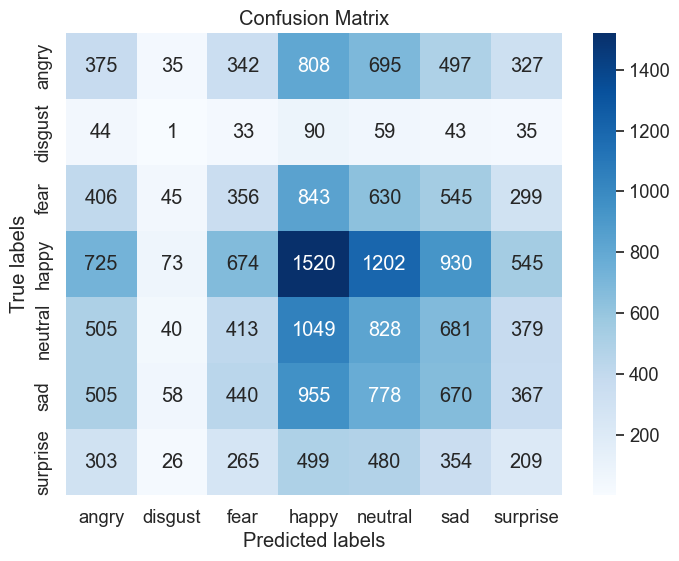

In [50]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


predictions = model.predict(training_set2)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = training_set2.classes
labels = ['angry', 'disgust', 'fear','happy', 'neutral', 'sad', 'surprise']

conf_matrix = confusion_matrix(true_labels, predicted_labels)


plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [51]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,   ## rescale or normalize the images pixels, by dividing them 255
    shear_range = 0.2,  ## angle for slant of image in degrees
    zoom_range = 0.2,   ## for zoom in or out
    horizontal_flip = True 
)
training_set = train_datagen.flow_from_directory(
    'D:\\movie-recommendation-system\\Emotion_detection\\data\\train',   ## give path of training set
    target_size=(48,48),      ## target_size of image in which you want
    batch_size=32,
    color_mode = "grayscale",
    class_mode = 'categorical'
)

Found 27472 images belonging to 7 classes.


In [52]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(
    'D:\\movie-recommendation-system\\Emotion_detection\\data\\test',
    target_size = (48,48),
    batch_size = 32,
    color_mode = "grayscale",
    class_mode = 'categorical'
)

Found 7178 images belonging to 7 classes.


In [53]:
train_loss, train_acc = model.evaluate(training_set)
test_loss, test_acc   = model.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

225/225 [==============================] - 75s 334ms/step - loss: 0.8018 - accuracy: 0.7208
final train accuracy = 84.41 , validation accuracy = 72.08
